In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
# from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from circuit import Circuit
import numpy as np
import dgl.function as fn
import random
import networkx as nx
from utils import *

Using backend: pytorch


In [2]:
design = "ldpc_GNN"
cir = Circuit(design)
f1 = "ldpc_GNN/ldpc_GNN.v"
cir.parseVerilog(f1)
f2 = "ldpc_GNN/die0.rpt"
cir.parsePartition(f2)
stil = "ldpc_GNN/TDF.stil"
cir.parseSTIL(stil)

Start parsing verilog netlist
nodeID: 182460
End parsing verilog netlist
CPU time: 1.84s

Start parsing partition report
End parsing partition report
CPU time: 0.02s

Start parsing STIL patterns
Pass Pattern 0
Pattern 1 success!
Pattern 2 success!
Pattern 3 success!
Pattern 4 success!
Pattern 5 success!
Pattern 6 success!
Pattern 7 success!
Pattern 8 success!
Pattern 9 success!
Pattern 10 success!
Pattern 11 success!
Pattern 12 success!
Pattern 13 success!
Pattern 14 success!
Pattern 15 success!
Pattern 16 success!
Pattern 17 success!
Pattern 18 success!
Pattern 19 success!
Pattern 20 success!
Pattern 21 success!
Pattern 22 success!
Pattern 23 success!
Pattern 24 success!
Pattern 25 success!
Pattern 26 success!
Pattern 27 success!
Pattern 28 success!
Pattern 29 success!
Pattern 30 success!
Pattern 31 success!
Pattern 32 success!
Pattern 33 success!
Pattern 34 success!
Pattern 35 success!
Pattern 36 success!
Pattern 37 success!
Pattern 38 success!
Pattern 39 success!
Pattern 40 success!

Pattern 387 success!
Pattern 388 success!
Pattern 389 success!
Pattern 390 success!
Pattern 391 success!
Pattern 392 success!
Pattern 393 success!
Pattern 394 success!
Pattern 395 success!
Pattern 396 success!
Pattern 397 success!
Pattern 398 success!
Pattern 399 success!
Pattern 400 success!
Pattern 401 success!
Pattern 402 success!
Pattern 403 success!
Pattern 404 success!
Pattern 405 success!
Pattern 406 success!
Pattern 407 success!
Pattern 408 success!
Pattern 409 success!
Pattern 410 success!
Pattern 411 success!
Pattern 412 success!
Pattern 413 success!
Pattern 414 success!
Pattern 415 success!
Pattern 416 success!
Pattern 417 success!
Pattern 418 success!
Pattern 419 success!
Pattern 420 success!
Pattern 421 success!
Pattern 422 success!
Pattern 423 success!
Pattern 424 success!
Pattern 425 success!
Pattern 426 success!
Pattern 427 success!
Pattern 428 success!
Pattern 429 success!
Pattern 430 success!
Pattern 431 success!
Pattern 432 success!
Pattern 433 success!
Pattern 434 s

In [3]:
edge = CreateGraphByFaultSite(cir)
dic, topEdge = backprop(cir)

hg = dgl.heterograph({ ('topNode', 'topEdge', 'faultSite'): topEdge, ('faultSite', 'net', 'faultSite'): edge })
print(hg)

Graph(num_nodes={'faultSite': 182460, 'topNode': 2048},
      num_edges={('faultSite', 'net', 'faultSite'): 247285, ('topNode', 'topEdge', 'faultSite'): 2739466},
      metagraph=[('faultSite', 'faultSite', 'net'), ('topNode', 'faultSite', 'topEdge')])


In [4]:
feats = torch.tensor([cir.Node[n].net.feats for n in cir.Node])
hg.nodes['faultSite'].data['feats'] = feats
hg.nodes['faultSite'].data['in_degree'] = hg.in_degrees(etype='net').view(-1,1).float()
hg.nodes['faultSite'].data['out_degree'] = hg.out_degrees(etype='net').view(-1,1).float()
hg.nodes['faultSite'].data['top_degree'] = hg.in_degrees(etype='topEdge').view(-1,1).float()
hg.nodes['faultSite'].data['level'] = getLevel(cir)
hg.nodes['faultSite'].data['loc'] = getLocation(cir, hg.num_nodes('faultSite'))

In [5]:
dataset = getDatasetfromLog(cir, dic, hg, 560, 5000)
subgraphs = getSubgraphs(hg, dataset)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [6]:
from dgl.nn import GatedGraphConv, GraphConv
from dgl.nn import SortPooling, SumPooling, MaxPooling
from dgl.nn import GlobalAttentionPooling
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = GraphConv(9, 32)
        self.conv2 = GraphConv(32, 3)

    
    def forward(self, g, in_feat):
#         g, in_feat = self.subgraph(hg, d)
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h_final'] = h
        return dgl.mean_nodes(g, 'h_final')


In [7]:
from collections import Counter
random.shuffle(subgraphs)
numtrain = int(len(subgraphs)*0.7)
numval = int(len(subgraphs)*0.85)
train_set = subgraphs[:numtrain]
val_set = subgraphs[numtrain:numval]
test_set = subgraphs[numval:]

train_l = [i[1] for i in train_set]
val_l = [i[1] for i in val_set]
test_l = [i[1] for i in test_set]
print("Training label: {}".format(Counter(train_l).values()))
print("Validation label: {}".format(Counter(val_l).values()))
print("Test label: {}".format(Counter(test_l).values()))


Training label: dict_values([1257, 1498, 745])
Validation label: dict_values([264, 335, 151])
Test label: dict_values([281, 314, 155])


In [8]:
model = Model().to('cuda')
# g = g.to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []

for epoch in range(50):
    print("\nEpoch %d:" %epoch)
    print("Training...")
    model.train()
    
    train_acc = 0
    train_loss = 0
    num_tests = 0
    for g, l in train_set:
        g = g.to('cuda')
        labels = torch.tensor([l]).to('cuda')
        g = dgl.add_reverse_edges(g)
        g = dgl.add_self_loop(g)

        infeats = g.ndata['infeats']
        
        
        pred = model(g, infeats)
        loss = F.cross_entropy(pred, labels)
#         l1_lambda = 0.001
#         l1_norm = sum(p.abs().sum() for p in model.parameters())
#         loss = loss + l1_lambda * l1_norm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc += (pred.argmax(1) == labels).sum().item()
        train_loss += loss
        num_tests += 1

    avg_loss = train_loss/num_tests
    avg_acc = train_acc/num_tests
    train_loss_values.append(avg_loss)
    train_acc_values.append(avg_acc)

    print('In epoch {}, train loss: {:.3f}, train acc: {:.3f}'.format(epoch, avg_loss, avg_acc))
    
    print("Validation...")
    model.eval()
    val_acc = 0
    val_loss = 0
    num_tests = 0

    random.shuffle(val_set)
    with torch.no_grad():
        for g, l in val_set:
            g = g.to('cuda')
            labels = torch.tensor([l]).to('cuda')
            g = dgl.add_reverse_edges(g)
            g = dgl.add_self_loop(g)
            
            infeats = g.ndata['infeats']
            
            pred = model(g, infeats)
            loss = F.cross_entropy(pred, labels)
            optimizer.zero_grad()

            val_acc += (pred.argmax(1) == labels).sum().item()
            val_loss += loss
            num_tests += 1

            
    avg_loss = val_loss/num_tests
    avg_acc = val_acc/num_tests
    val_loss_values.append(avg_loss)
    val_acc_values.append(avg_acc)
        
    print('In epoch {}, val loss: {:.3f}, val acc: {:.3f}'.format(epoch, avg_loss, avg_acc))
    
    scheduler.step()
    
model.eval()
test_acc = 0
test_loss = 0
num_tests = 0

with torch.no_grad():
    for g, l in test_set:
        g = g.to('cuda')
        labels = torch.tensor([l]).to('cuda')
        g = dgl.add_reverse_edges(g)
        g = dgl.add_self_loop(g)
        infeats = g.ndata['infeats']

        pred = model(g, infeats)
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()

        test_acc += (pred.argmax(1) == labels).sum().item()
        test_loss += loss
        num_tests += 1


avg_loss = test_loss/num_tests
avg_acc = test_acc/num_tests

print("test accuracy: {}".format(avg_acc))


Epoch 0:
Training...
In epoch 0, train loss: 0.820, train acc: 0.731
Validation...
In epoch 0, val loss: 0.481, val acc: 0.801

Epoch 1:
Training...
In epoch 1, train loss: 0.456, train acc: 0.810
Validation...
In epoch 1, val loss: 0.377, val acc: 0.860

Epoch 2:
Training...
In epoch 2, train loss: 0.372, train acc: 0.850
Validation...
In epoch 2, val loss: 0.378, val acc: 0.860

Epoch 3:
Training...
In epoch 3, train loss: 0.349, train acc: 0.865
Validation...
In epoch 3, val loss: 0.368, val acc: 0.869

Epoch 4:
Training...
In epoch 4, train loss: 0.338, train acc: 0.868
Validation...
In epoch 4, val loss: 0.369, val acc: 0.875

Epoch 5:
Training...
In epoch 5, train loss: 0.328, train acc: 0.874
Validation...
In epoch 5, val loss: 0.384, val acc: 0.853

Epoch 6:
Training...
In epoch 6, train loss: 0.320, train acc: 0.879
Validation...
In epoch 6, val loss: 0.376, val acc: 0.859

Epoch 7:
Training...
In epoch 7, train loss: 0.309, train acc: 0.881
Validation...
In epoch 7, val loss

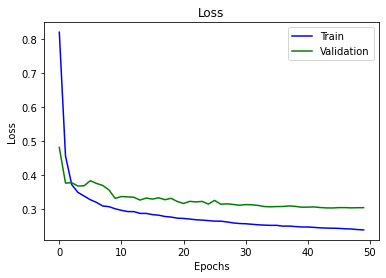

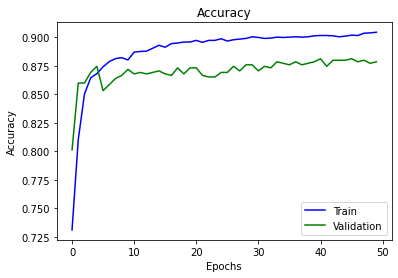

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,len(train_loss_values),1), train_loss_values,'b', np.arange(0,len(val_loss_values),1), val_loss_values, 'g')
plt.legend(["Train", "Validation"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0,len(train_acc_values),1), train_acc_values,'b', np.arange(0,len(val_acc_values),1), val_acc_values, 'g')
# plt.plot(np.arange(0,25,1), train_acc_values[-25:],'b', np.arange(0,25,1), val_acc_values[-25:], 'g')

plt.legend(["Train", "Validation"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


# 